# Comparing Pixel Alignment methods

Compares using a PixelTrees and MOCs, or using Skymaps and order maps as a method of finding pairs of matching partitions from catalogs with overlapping coverage tracked at a higher order. 

In [1]:
import healpy as hp
import lsdb
import numpy as np
import pandas as pd
from hipscat.inspection import plot_pixels, plot_pixel_list
from hipscat.io.file_io import read_fits_image
from hipscat.pixel_tree import PixelAlignment, align_trees

from mocpy import MOC

from numba import njit
import numba
from hipscat.pixel_tree.pixel_tree import PixelTree

# Gaia x ZTF object catalogs

Our first test case is on the GAIA and ZTF object catalogs. ZTF has 2352 partitions, and GAIA 3933.

## Skymaps

First create skymaps for gaia and ztf. Code for creating skymaps and getting mappings by Mario Juric from [this notebook](https://github.com/mjuric/incubator/blob/master/hipscat-fast-join/compute-join-pairs.ipynb)

In [ ]:
def compute_omap(path):
    # Infer the HiPS hierarchy from scanning the directory tree
    import glob, re
    maps = dict()
    npart = 0
    for fn in glob.glob(f"{path}/*/*/*.parquet"):
        if m:= re.search(r'Norder=(\d+)/Dir=\d+/Npix=(\d+)', fn):
            o, ipix = map(int, m.group(1, 2))
            if o not in maps:
                maps[o] = np.zeros(hp.order2npix(o), dtype=int)
            maps[o][ipix] = o + 1
            npart += 1

    # Flatten the result into a high-order map
    order_out = max(maps.keys())
    nside_out = hp.order2nside(order_out)
    omap = np.zeros(hp.order2npix(order_out), dtype=int)
    for o, m in maps.items():
        upscaled = hp.ud_grade(m, nside_out, dtype=int, order_in='NESTED', order_out='NESTED')
        omap[:] += upscaled

    return (omap - 1).astype('i1'), npart

def skymap_aux(fn, order):
    nside = hp.order2nside(order)

    df = pd.read_parquet(fn, columns='ra dec'.split())
    ipix = hp.ang2pix(nside, df["ra"], df["dec"], nest=True, lonlat=True)
    i, ct = np.unique(ipix, return_counts=True)

    return i, ct

def compute_skymap(path, order):
    from functools import partial
    from rich.progress import track
    import glob, psutil
    import multiprocessing as mp

    img = np.zeros(hp.order2npix(order), dtype=int)
    fns = list(glob.glob(f"{path}/*/*/*.parquet"))

    ncores = psutil.cpu_count(logical=False) // 10
    with mp.Pool(processes=ncores) as pool:
        for i, ct in track(pool.imap_unordered(partial(skymap_aux, order=order), fns), total=len(fns)):
            img[i] += ct

    return img

In [3]:
skymap_order = 9

for catfn, catname in zip(["/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14"], ["gaia", "ztf"]):
    
    omap1, npart1 = compute_omap(catfn)
    
    # skymap1 = compute_skymap(catfn, order=skymap_order).astype(bool)
    
    skymap_path = f"/data3/epyc/projects3/sean_hipscat/skymap{catname}.npy"
    omap_path = f"/data3/epyc/projects3/sean_hipscat/omap{catname}.npy"
    
    # np.save(skymap_path, skymap1)
    # np.save(omap_path, omap1)
    
    # mapread = np.load(skymap_path)
    omapread = np.load(omap_path)
    
    # assert np.all(mapread == skymap1)
    assert np.all(omapread == omap1)

The skymaps and order maps are created and saved as numpy arrays, to avoid having to compute them each time the notebook is run. These would be stored in metadata so the performance of this part isn't important.

In [4]:
skymap_gaia = np.load("/data3/epyc/projects3/sean_hipscat/skymapgaia.npy")
omap_gaia = np.load("/data3/epyc/projects3/sean_hipscat/omapgaia.npy")
skymap_ztf = np.load("/data3/epyc/projects3/sean_hipscat/skymapztf.npy")
omap_ztf = np.load("/data3/epyc/projects3/sean_hipscat/omapztf.npy")

In [56]:
def hp_rescale(img, order_out):
    #
    # Change the order of a healpix image. This function has different
    # behaviors depending on whether the image is upscaled or downscaled.
    # Maintains dtype. If order_out is equal to existing order, no copy
    # is made.
    #
    # upscaling: higher order pixels are filled with the value of the
    #            value of the lower-order pixel. I.e., for Δo=1 change:
    #                [... 2 ...] -> [... 2 2 2 2 ...]
    #
    # downscaling: lower order pixel is filled with the *sum* of lower order
    #              pixels. I.e., for Δo=1 change:
    #                [... 1 3 5 7 ...] -> [ ... 16 ... ]
    #              WARNING: the dtype of the input img is used for the accumulator.
    #                This could cause overflows if input dtype is narrow.
    #
    # An identity transformation requires division by 2**(2*|o1-o2\). Example:
    #
    #   o2, o1 = 2, 1
    #   x1 = np.arange(hp.order2npix(o1))
    #   x2 = hp_rescale(hp_rescale(x1, o2), o1) >> (2*np.abs(o2-o1))
    #   print(f"{x1}\n{x2}")
    #
    #   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    #    24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
    #   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    #    24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
    #
    o = (int(np.log2(len(img) // 3)) >> 1) - 1 ## this is a fast hp.npix2order impl.

    if order_out > o:
        # upscale
        dim2 = 1 << 2*(order_out-o)
        return np.repeat(img[:, None], dim2, axis=1).flatten()
    elif order_out < o:
        # downscale
        dim2 = 1 << 2*(o-order_out)
        return img.reshape((len(img) // dim2, dim2)).sum(axis=1, dtype=img.dtype)

    return img


def compute_join_pairs(skymap1, skymap2, omap1, omap2):
    # Compute the partition pairs needed to perform an inner join
    # between two tables. Do it quickly (~10-100ms, even for large
    # catalogs).
    #
    # Inputs:
    #  - skymap1/2: high healpix-order counts maps of both catalogs.
    #  - omap1/2: order maps of both catalogs
    #
    # For best performance (both speed & memory):
    #  - have all skymaps/omaps at the same order.
    #  - have all omaps as dtype='i1'
    #  - have the skymaps as dtype=bool (i.e., True if there's data
    #    in that pixel, false otherwise).
    # If these are not satisfied, this function will convert the input
    # as needed, at some performance cost.
    #
    # Author: mjuric@uw.edu
    #

    maxlen = max(len(omap1), len(omap2), len(skymap1), len(skymap2))
    o = hp.npix2order(maxlen)

    skymap1 = hp_rescale(skymap1, o).astype(bool, copy=False)
    skymap2 = hp_rescale(skymap2, o).astype(bool, copy=False)
    omap1 = hp_rescale(omap1, o).astype('i1', copy=False)
    omap2 = hp_rescale(omap2, o).astype('i1', copy=False)

    # Pixels on the sky where there's overlapping data
    mask, = np.nonzero(skymap1 & skymap2)
    mask = mask.view('u8')  ## otherwise subsequent bit shifting won't work correctly

    ## find orders of those pixels, in both catalogs
    o1 = omap1[mask].astype('u8')  ## need to widen for subsequent bitshifting to work
    o2 = omap2[mask].astype('u8')  ## need to widen for subsequent bitshifting to work

    ## Find Npixel numbers for those pixels, in both catalogs
    ipix1 = mask >> (2 * (o - o1))
    ipix2 = mask >> (2 * (o - o2))
    
    print(o)

    if o <= 12:  ## Fast path
        ## pack it all into a 64-bit integer for _really_ fast np.unique (~15x faster than multi-D array variant)
        ## bit layout: [o1|4bits][ipix1|28bits][o2|4bits][ipix2|28bits]
        ## works for order <= 12
        
        print("fast")
        combined = ipix2
        combined |= o2 << 28
        combined |= ipix1 << 32
        combined |= o1 << 60
        pairs = np.unique(combined)

        ## unpack
        ipix2 = pairs & 0x00000000_0FFFFFFF
        ipix1 = pairs & 0x0FFFFFFF_00000000;
        ipix1 >>= 32
        o2 = pairs & 0x00000000_F0000000;
        o2 >>= 28
        o1 = pairs >> 60
    else:  ## Universal path
        combined = np.vstack([o1, ipix1, o2, ipix2], dtype='u4')
        pairs = np.unique(combined, axis=1)

        o1, ipix1, o2, ipix2 = pairs.astype(
            'u8')  # convert to u8 to maintain the same return datatype as the fast variant

    return (o1, ipix1, o2, ipix2)

We run the `compute_join_pairs` method for gaia and ztf to get the following results

In [ ]:
(o1, ipix1, o2, ipix2) = compute_join_pairs(skymap_gaia, skymap_ztf, omap_gaia, omap_ztf)
df = pd.DataFrame(dict(o1=o1, ipix1=ipix1, o2=o2, ipix2=ipix2))
df

## PixelTree

We'll use LSDB to read the gaia and ztf catalogs, since this creates the pixel trees as part of the lazy catalog creation.

In [7]:
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

### MOCs

To get the same resolution as the skymap alignments, we can use MOCs of the catalogs to compute the intersections of their coverages and filter the pixel tree alignments by pixels that appear in the MOC. We can make a MOC from the skymap in this case by initializing it from the healpix pixels that appear in the skymap, using the MOCpy library.

In [8]:
def moc_from_skymap(map, map_order):
    ipix = np.where(map)[0]
    orders = np.full(ipix.shape, map_order)
    return MOC.from_healpix_cells(ipix, orders, map_order)

In [9]:
ztf_moc = moc_from_skymap(skymap_ztf, skymap_order)
ztf_moc

1/1 12 14 19 21-23 31 
2/0-2 8-9 11-14 16-18 20-22 24 26-27 29-30 34-35 37-39 45 52-54 60-61 67 69 71 
 73-75 83 109-110 119 
3/12-14 40 42-43 61-62 76-78 92-94 100-101 103 112-114 124 126 131 133-135 
 144-146 160 162-166 168-169 171 173 175-177 179 184 220 222-223 248-250 253 
 265-267 273 275 281-283 289-291 329-331 426-427 430 444-445 469 471-472 475 
 492 565-567 570-571 573-575 639 767 
4/60-62 164-165 167 240 242-243 252 317-319 380 382-383 408 410-411 461-463 
 500-502 508-509 515-516 519 529-531 588 590-591 647 668-669 671 680-681 683 
 688-689 691 696-697 699 712 714-715 740-742 745-746 750 753-756 885-887 
 1004-1006 1008-1010 1016-1017 1020 1039 1045-1046 1048-1049 1051-1052 
 1054-1055 1059 1088-1089 1091 1097 1099 1121-1123 1152-1153 1295 1303 
 1305-1307 1309-1311 1315 1661-1663 1702-1703 1712 1715 1717-1719 1725 1727 
 1733 1742-1743 1784 1786-1788 1790-1791 1867-1868 1870-1871 1873 1875 
 1881-1883 1892-1894 1897-1899 1941-1943 1945-1950 1972 1974-1975 1979 
 1981-1983

In [10]:
gaia_moc = moc_from_skymap(skymap_gaia, skymap_order)
gaia_moc

0/0-9 11 
1/40 42-43 
2/164-166 
3/668-670 
4/2684-2685 2687 
5/10744 10746-10747 
6/42980 42982-42983 
7/171924-171926 
8/687709-687711 
9/2750832-2750833 2750835 

Our interval pixel trees and mocs use very similar data structures of ranges of HEALPix values, with the pixel tree keeping track of the individual healpix pixels that have partitions, and the MOCs merging adjacent pixels into larger ranges spanning multiple pixels. So to filter by a MOC, we can do a similar method to the pixel tree alignment looping through both lists, but in this case just keeping track of which pixel tree partitions overlap with the MOC.

In [11]:
def filter_by_moc(
        tree: PixelTree,
        moc: MOC,
) -> PixelTree:
    moc_ranges = moc.to_depth29_ranges
    tree_29_ranges = tree.tree << (2 * (29 - tree.tree_order))
    tree_mask = perform_filter_by_moc(tree_29_ranges, moc_ranges)
    return PixelTree(tree.tree[tree_mask], tree.tree_order)

@njit(numba.bool_[::1](numba.int64[:, :], numba.uint64[:, :],))
def perform_filter_by_moc(
        tree: np.ndarray,
        moc: np.ndarray,
) -> np.ndarray:
    """Performs filtering with lists of pixel intervals"""
    output = np.full(tree.shape[0], fill_value=False, dtype=np.bool_)
    tree_index = 0
    moc_index = 0
    while tree_index < len(tree) and moc_index < len(moc):
        tree_pix = tree[tree_index]
        moc_pix = moc[moc_index]
        if tree_pix[0] >= moc_pix[1]:
            # Don't overlap, tree pixel ahead so move onto next MOC pixel
            moc_index += 1
            continue
        if moc_pix[0] >= tree_pix[1]:
            # Don't overlap, MOC pixel ahead so move onto next tree pixel
            tree_index += 1
            continue
        # Pixels overlap, so include current tree pixel and check next tree pixel
        output[tree_index] = True
        tree_index += 1
    return output

In [12]:
def filter_alignment_by_moc(alignment: PixelAlignment, moc: MOC) -> PixelAlignment:
    moc_ranges = moc.to_depth29_ranges
    tree_29_ranges = alignment.pixel_tree.tree << (2 * (29 - alignment.pixel_tree.tree_order))
    tree_mask = perform_filter_by_moc(tree_29_ranges, moc_ranges)
    new_tree = PixelTree(alignment.pixel_tree.tree[tree_mask], alignment.pixel_tree.tree_order)
    return PixelAlignment(new_tree, alignment.pixel_mapping.iloc[tree_mask], alignment.alignment_type)

def align_with_mocs(left, right, mocl, mocr):
    intersection = mocl.intersection(mocr)
    alignment = align_trees(left, right)
    return filter_alignment_by_moc(alignment, intersection)    

Performing the same alignment with ZTF and GAIA with their MOCs, we see the results we get from this method.

In [13]:
gaia_ztf_alignment = align_with_mocs(gaia.hc_structure.pixel_tree, ztf.hc_structure.pixel_tree, gaia_moc, ztf_moc)
gaia_ztf_alignment.pixel_mapping

,primary_Norder,primary_Npix,join_Norder,join_Npix,aligned_Norder,aligned_Npix
0,2,0,3,0,3,0
1,2,0,3,1,3,1
2,2,0,3,2,3,2
3,2,0,3,3,3,3
4,3,4,3,4,3,4
...,...,...,...,...,...,...
3043,4,3067,4,3067,4,3067
3044,3,767,4,3068,4,3068
3045,3,767,4,3069,4,3069
3046,3,767,4,3070,4,3070


We can then compare the results to make sure they match

In [14]:
# Get the same dataframe format as the skymap results from the tree alignment

dftree = gaia_ztf_alignment.pixel_mapping[["primary_Norder", "primary_Npix", "join_Norder", "join_Npix"]].sort_values(["primary_Norder", "primary_Npix", "join_Norder", "join_Npix"])
dftree

,primary_Norder,primary_Npix,join_Norder,join_Npix
0,2,0,3,0
1,2,0,3,1
2,2,0,3,2
3,2,0,3,3
11,2,2,3,8
...,...,...,...,...
1980,7,117019,5,7313
1986,7,117040,5,7315
1987,7,117041,5,7315
1988,7,117042,5,7315


In [15]:
tree_match_set = set([tuple(i) for i in dftree.values])
match_set = set([tuple(i) for i in df.values])
assert len(tree_match_set.difference(match_set)) == 0
assert len(match_set.difference(tree_match_set)) == 0

The sets of rows mapping left and right pixels have no difference, so both methods produce the same results


We can plot these pixel maps to visualize the result we get

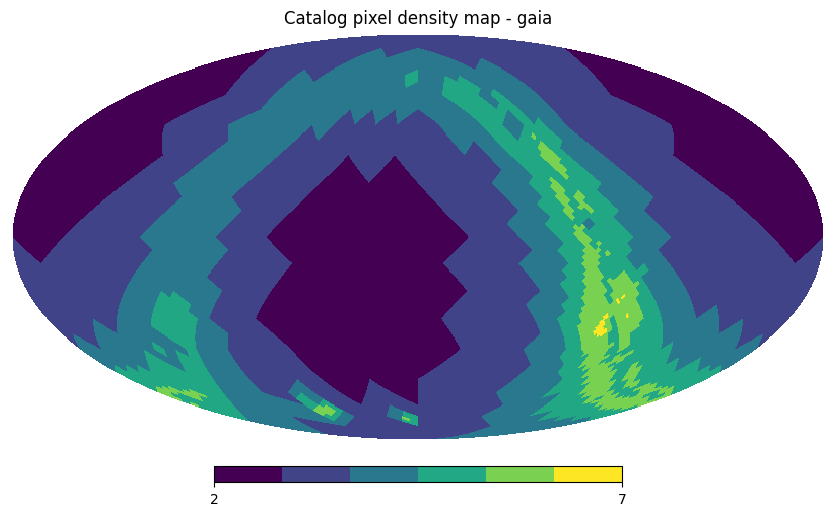

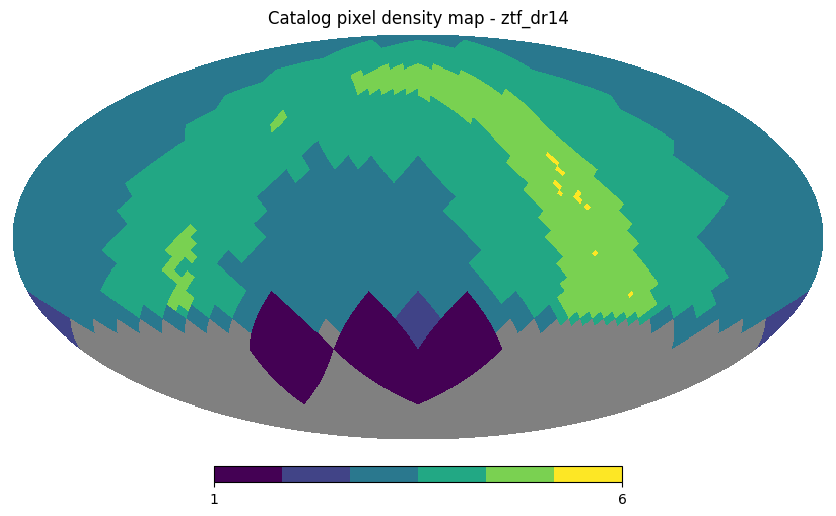

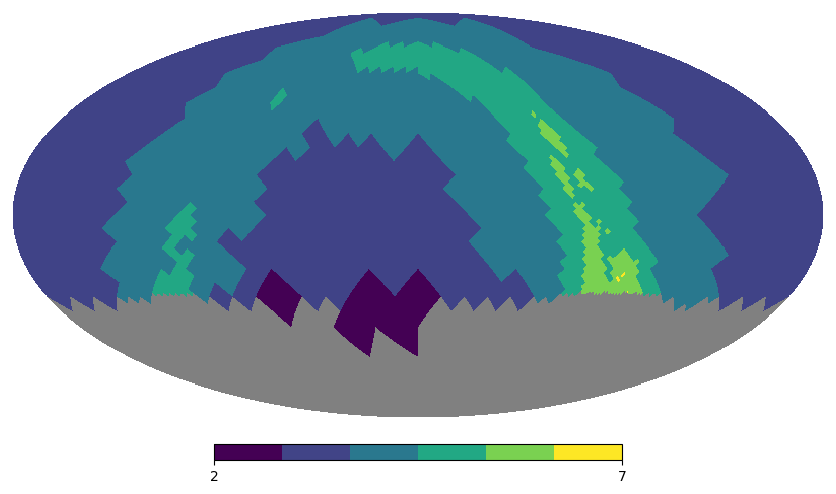

In [16]:
plot_pixels(gaia.hc_structure)
plot_pixels(ztf.hc_structure)
plot_pixel_list(gaia_ztf_alignment.pixel_tree.get_healpix_pixels())

## Comparing Time Performance

In [17]:
%timeit compute_join_pairs(skymap_gaia, skymap_ztf, omap_gaia, omap_ztf)

287 ms ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit align_with_mocs(gaia.hc_structure.pixel_tree, ztf.hc_structure.pixel_tree, gaia_moc, ztf_moc) 

3.32 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see better performance with the pixel tree and moc method, likely due to the arrays being much smaller since they only store the ranges of values where the pixels are occupied, instead of the full array of all pixels.

## Memory usage

The memory usage in MB of the data structures also follows this pattern with the sparse Pixel Trees needing less elements than the densly packed Skymaps.

In [19]:
skymap_ztf.nbytes / 1024 / 1024

3.0

In [20]:
ztf.hc_structure.pixel_tree.tree.nbytes / 1024 / 1024

0.035888671875

In [21]:
ztf_moc.to_depth29_ranges.nbytes / 1024 / 1024

0.1168975830078125

The MOCpy library uses Rust code, making evaluating its memory in python hard, but I think this is a good estimate of the memory it uses, since I think the representation in memory they use is ranges at Order 29, the same as this numpy array in python.

## ZTF Object x ZTF Source

The biggest catalog we have imported until now is the ZTF Source catalog that was generated with a low partition threshold that resulted in ~300,000 partitions. This is a bit unrealistic, as the better imported ZTF source catalog has only ~40,000 partitions, but a good stress test in preperation for Rubin's data volume. 

Generating the skymap from reading the HiPSCat files would take hours, but we do have the `point_map.fits` file that contains the same information at order 10, so we can use that to load the skymap.

In [22]:
ztf_source_path = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source/"

In [23]:
ztf_source_fits = read_fits_image(f"{ztf_source_path}point_map.fits")
ztf_source_fits

array([ 5431,  4036,  8964, ..., 21724, 24985, 21038])

Plotting the histogram with a log scale to see the data looks correct

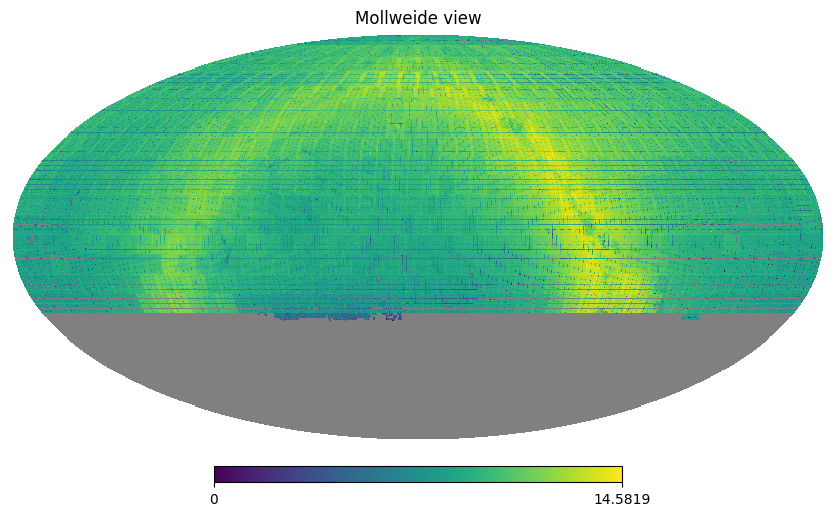

In [24]:
ztf_source_plot_map = ztf_source_fits.astype(float)
ztf_source_plot_map[ztf_source_fits == 0] = hp.UNSEEN
ztf_source_plot_map[ztf_source_fits > 0] = np.log(ztf_source_plot_map[ztf_source_fits > 0])
hp.mollview(ztf_source_plot_map, nest=True)

The skymap we need for our mappings is just this histogram as boolean values across the whole sky.

In [25]:
ztf_source_skymap_order = 10

skymap_ztf_source = np.zeros(hp.order2npix(ztf_source_skymap_order), dtype=int)
skymap_ztf_source[np.arange(len(ztf_source_fits))] = ztf_source_fits
skymap_ztf_source = skymap_ztf_source.astype(bool)
skymap_ztf_source

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
omap_ztf_source, _ = compute_omap(ztf_source_path)
omap_ztf_source

array([6, 6, 6, ..., 7, 7, 7], dtype=int8)

We can get the pixel tree and MOC reading with LSDB and using the skymap in the same way as before

In [27]:
ztf_source = lsdb.read_hipscat(ztf_source_path)

In [28]:
ztf_source_moc = moc_from_skymap(skymap_ztf_source, ztf_source_skymap_order)
ztf_source_moc

4/137 1117 1134 1273 1876 2263 2293 
5/0 2 5-6 9-10 13 15 19-20 23-24 29-30 35-36 40 43-46 49-50 55 57-60 65-66 71 
 73-76 79-80 83 85-86 89-90 93-94 96 99-101 104-106 109-111 113 115 119 
 123-125 128-130 133 135 139-141 143-145 147-150 152-154 157 159-160 162 164 
 166 169-170 173-175 177-179 181 183 187-189 193 195 199-200 203-204 208 211 
 213-214 217-218 221 223-224 228-230 233-234 237-238 241-243 247 250-252 255 
 258 260 264 267 272 275 277-278 281-282 285-286 288 293-294 297-298 301 303 
 305-307 311 313 315-316 319 321 323 325 327 330-332 335-336 339-340 344 
 347-350 352 355-356 359-360 363-365 369-370 373-374 377 381-382 385 388 391 
 395-396 399-400 403-404 408 411-412 414 416 419-420 424 427 433 435 437-438 
 441-442 445-446 448-450 453-454 456-458 461-462 465-466 469-470 475 479 
 481-482 485-487 490-492 495-496 499-500 503-504 507 511 513-515 519-520 
 523-524 528 530-531 533-534 537-538 542-544 547 553-554 558-559 562 564 567 
 571-572 575 577-578 583 587-588 591-592 59

We'll define a helper function to make sure the methods generate identical results

In [29]:
def assert_methods_equal_results(smap1, smap2, omap1, omap2, cat1, cat2, moc1, moc2):
    (o1, ipix1, o2, ipix2) = compute_join_pairs(smap1, smap2, omap1, omap2)
    df = pd.DataFrame(dict(o1=o1, ipix1=ipix1, o2=o2, ipix2=ipix2)).sort_values(["o1", "ipix1", "o2", "ipix2"])
    a = align_with_mocs(cat1.hc_structure.pixel_tree, cat2.hc_structure.pixel_tree, moc1, moc2)
    dftree = a.pixel_mapping[["primary_Norder", "primary_Npix", "join_Norder", "join_Npix"]].sort_values(["primary_Norder", "primary_Npix", "join_Norder", "join_Npix"])
    tree_match_set = set([tuple(i) for i in dftree.values])
    match_set = set([tuple(i) for i in df.values])
    assert len(tree_match_set.difference(match_set)) == 0
    assert len(match_set.difference(tree_match_set)) == 0

In [30]:
assert_methods_equal_results(skymap_ztf, skymap_ztf_source, omap_ztf, omap_ztf_source, ztf, ztf_source, ztf_moc, ztf_source_moc)

And we see that they match in this case as well

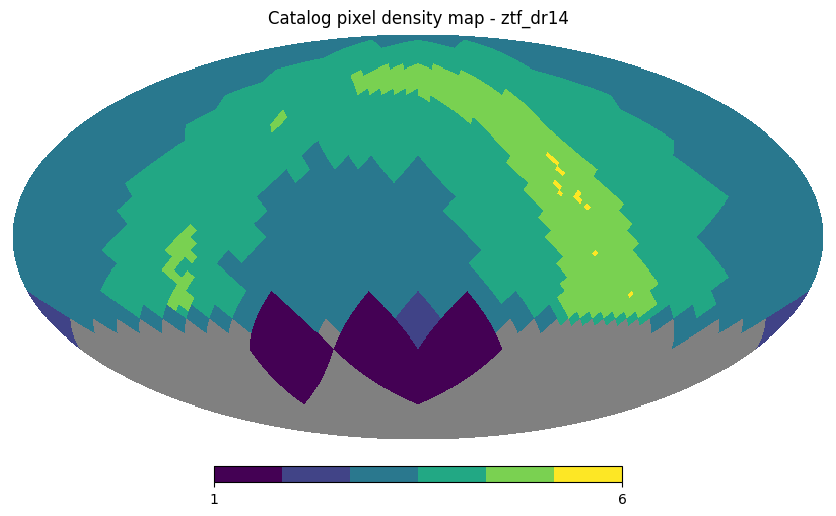

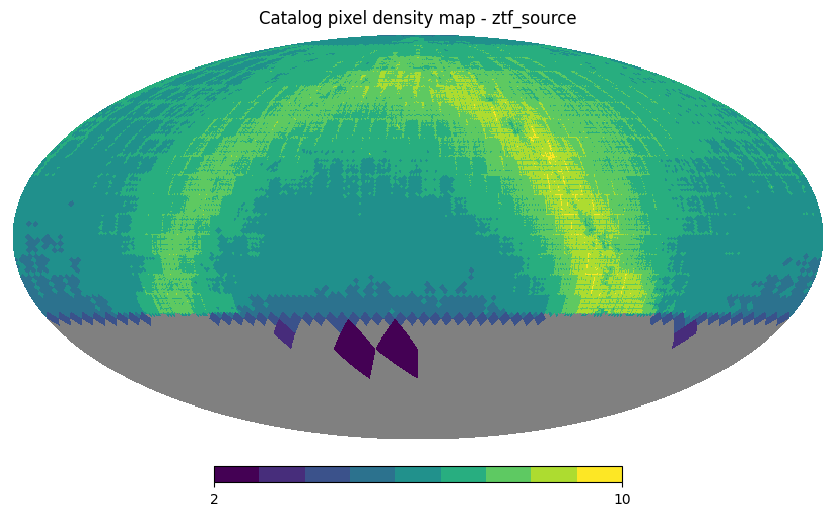

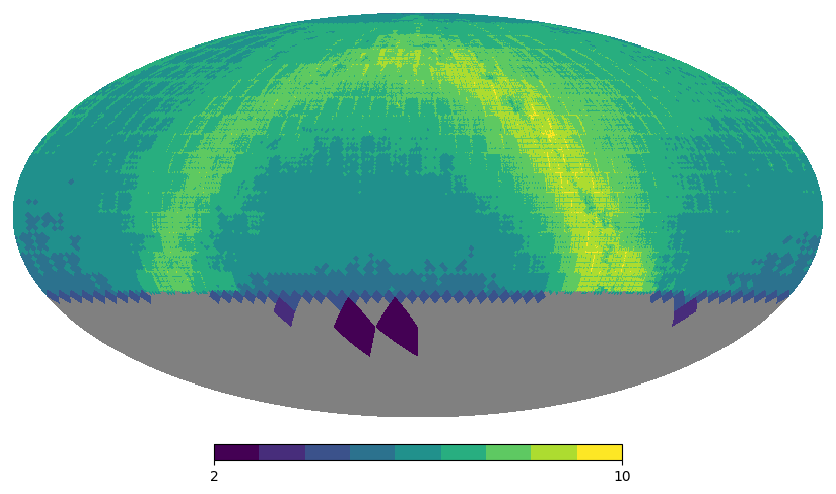

In [31]:
plot_pixels(ztf.hc_structure)
plot_pixels(ztf_source.hc_structure)
plot_pixel_list(align_with_mocs(ztf.hc_structure.pixel_tree, ztf_source.hc_structure.pixel_tree, ztf_moc, ztf_source_moc).pixel_tree.get_healpix_pixels())

## Performance

In [32]:
%timeit compute_join_pairs(skymap_ztf, skymap_ztf_source, omap_ztf, omap_ztf_source)

1.15 s ± 96.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit align_with_mocs(ztf.hc_structure.pixel_tree, ztf_source.hc_structure.pixel_tree, ztf_moc, ztf_source_moc)

140 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Memory

In [34]:
skymap_ztf_source.nbytes / 1024 / 1024

12.0

In [35]:
ztf_source.hc_structure.pixel_tree.tree.nbytes / 1024 / 1024

4.7460479736328125

In [36]:
ztf_source_moc.to_depth29_ranges.nbytes / 1024 / 1024

1.1358489990234375

With the skymap at order 10 and the highest partition order at order 10, there's less memory overhead storing the dense skymaps.

## Matching with Small Catalogs

The biggest benefit of keeping the coverage at a higher order is when there is an order mismatch and the lower order partitions are not entirely covered. Knowing the coverage at a higher order, we don't need to load all of the higher order partitions that match.

To test this, we can create a dummy catalog with a few points sparsely spread across the sky

In [37]:
dummy_catalog_ras = np.arange(0, 360)
dummy_catalog_decs = np.sin(dummy_catalog_ras) + 10
dummy_catalog_dataframe = pd.DataFrame.from_dict({"ra": dummy_catalog_ras, "dec": dummy_catalog_decs})

In [38]:
dummy_catalog = lsdb.from_dataframe(dummy_catalog_dataframe)
dummy_catalog

,ra,dec,Norder,Dir,Npix
npartitions=8,,,,,
0,int64,float64,uint8,uint64,uint64
1152921504606846976,...,...,...,...,...
...,...,...,...,...,...
8070450532247928832,...,...,...,...,...
18446744073709551615,...,...,...,...,...


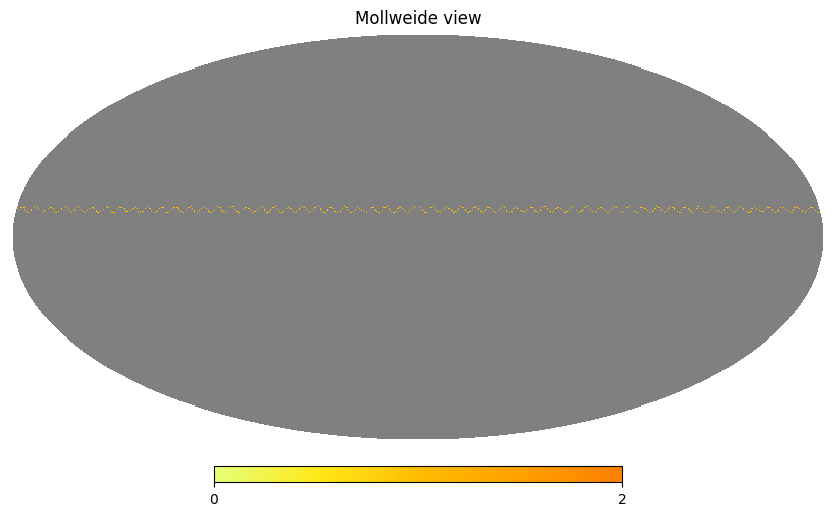

In [39]:
dummy_catalog.skymap(lambda x, _: len(x), order=7, plotting_args={"cmap": "Wistia"})

Here's what our dummy catalog looks like, with a very small number of points across the sky

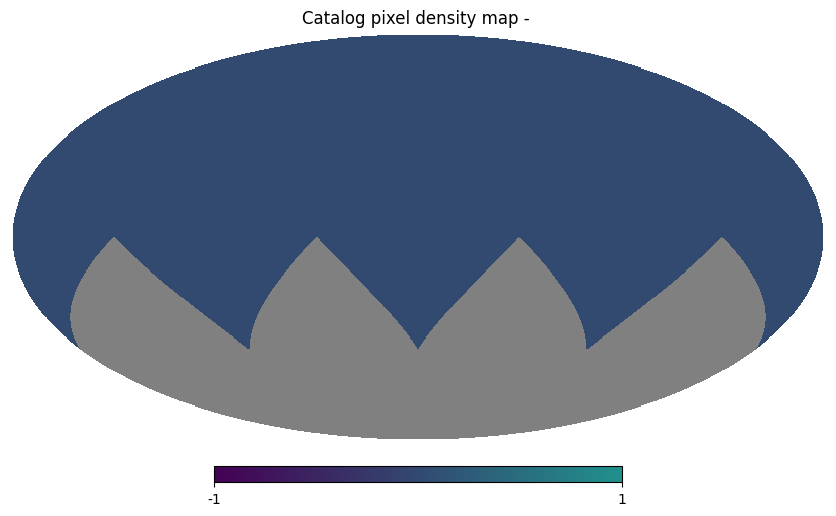

In [40]:
plot_pixels(dummy_catalog.hc_structure)

When we import this with hipscat, we use order 0 pixels since there are so few points, but since they're spread across the whole sky, the order 0 pixels cover a large portion of the sky.

We can modify the skymap and order map code to generate from in memory data structures for this test catalog

In [41]:
def compute_omap_catalog(catalog):
    # Infer the HiPS hierarchy from scanning the directory tree
    import glob, re
    maps = dict()
    npart = 0
    for pixel in catalog.get_healpix_pixels():
        o, ipix = pixel.order, pixel.pixel
        if o not in maps:
            maps[o] = np.zeros(hp.order2npix(o), dtype=int)
        maps[o][ipix] = o + 1
        npart += 1

    # Flatten the result into a high-order map
    order_out = max(maps.keys())
    nside_out = hp.order2nside(order_out)
    omap = np.zeros(hp.order2npix(order_out), dtype=int)
    for o, m in maps.items():
        upscaled = hp.ud_grade(m, nside_out, dtype=int, order_in='NESTED', order_out='NESTED')
        omap[:] += upscaled

    return (omap - 1).astype('i1'), npart

def skymap_aux_catalog(partition, order):
    nside = hp.order2nside(order)

    df = partition.compute()
    ipix = hp.ang2pix(nside, df["ra"], df["dec"], nest=True, lonlat=True)
    i, ct = np.unique(ipix, return_counts=True)

    return i, ct

def compute_skymap_catalog(catalog, order):
    from functools import partial
    from rich.progress import track
    import glob, psutil
    import multiprocessing as mp

    img = np.zeros(hp.order2npix(order), dtype=int)
    fns = catalog._ddf.partitions
    
    for pixel in catalog.get_healpix_pixels():
        i, ct = skymap_aux_catalog(catalog.get_partition(pixel.order, pixel.pixel), order)
        img[i] += ct
    return img

In [42]:
dummy_catalog_skymap = compute_skymap_catalog(dummy_catalog, skymap_order)
dummy_catalog_omap, _ = compute_omap_catalog(dummy_catalog)
dummy_catalog_skymap, dummy_catalog_omap

(array([0, 0, 0, ..., 0, 0, 0]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1], dtype=int8))

In [43]:
dummy_catalog_moc = moc_from_skymap(dummy_catalog_skymap, skymap_order)
dummy_catalog_moc

9/5402 5457 5518 5934 6388 6439 6513 6868 7265 7427 9447 9601 9681 9924 10474 
 10634 10736 10900 11365 11422 12380 12480 16451 32821 32947 267497 267684 
 267764 267836 268823 268847 269060 269140 269341 269489 271924 272000 272161 
 272219 272735 272895 272955 273261 273281 274447 274604 278604 278685 528368 
 529366 529750 529911 529983 530296 530309 530765 530925 531103 531364 531396 
 533487 533791 533949 534206 534423 534443 534832 534957 535448 557086 557320 
 791835 791973 792453 792823 792870 792922 793474 793696 793859 795896 796015 
 796033 796370 796907 797066 797135 797378 797797 797852 798783 798814 802880 
 819298 819378 1163238 1167325 1168810 1168918 1169031 1169232 1169969 1170186 
 1170255 1170471 1170606 1172443 1172855 1173050 1173119 1173333 1173356 
 1173863 1174157 1174239 1174354 1174466 1228794 1232855 1233918 1234475 
 1234529 1234739 1234783 1235423 1235649 1235827 1235857 1238001 1238340 
 1238501 1238753 1238892 1238960 1239319 1239477 1239957 1239982 1250

In [44]:
assert_methods_equal_results(skymap_ztf, dummy_catalog_skymap, omap_ztf, dummy_catalog_omap, ztf, dummy_catalog, ztf_moc, dummy_catalog_moc)

Mapping ZTF to this dummy catalog we see the same results between the methods

## Performance

In [45]:
%timeit compute_join_pairs(skymap_ztf, dummy_catalog_skymap, omap_ztf, dummy_catalog_omap)

32.1 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit align_with_mocs(ztf.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree, ztf_moc, dummy_catalog_moc)

1.67 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Performance of mapping ZTF Sources to the Dummy catalog

This is a bit of a worst case scenario, in that we have the dummy catalog with mostly empty order 0 pixels, and ZTF sources with very dense pixels going up to order 10

In [47]:
assert_methods_equal_results(skymap_ztf_source, dummy_catalog_skymap, omap_ztf_source, dummy_catalog_omap, ztf_source, dummy_catalog, ztf_source_moc, dummy_catalog_moc)

In [48]:
%timeit compute_join_pairs(skymap_ztf_source, dummy_catalog_skymap, omap_ztf_source, dummy_catalog_omap)

322 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit align_with_mocs(ztf_source.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree, ztf_source_moc, dummy_catalog_moc)

112 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Benefits of keeping higher order coverage

Compared to just using the pixel tree, this case really shows the benefits of these methods, where we only load the ztf source partitions that overlap with the actual data in the small area of the sky it covers, compared to loading the partitions that overlap with the pixels in the HiPSCat structure. The dummy catalog is a bit of an extreme example, but for smaller catalogs like the AGN catalog, users would be interested in we would still see these benefits to some extent.

In [50]:
len(align_with_mocs(ztf_source.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree, ztf_source_moc, dummy_catalog_moc).pixel_mapping)

354

In [51]:
len(align_trees(ztf_source.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree).pixel_mapping)

302553

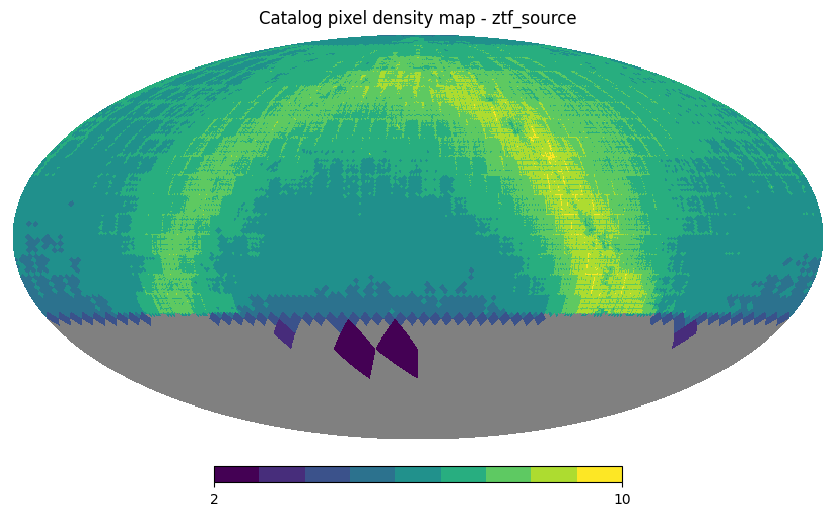

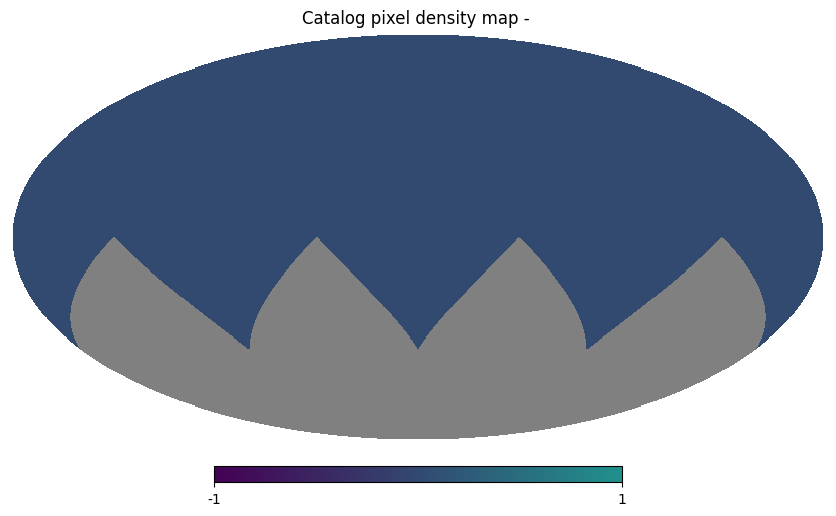

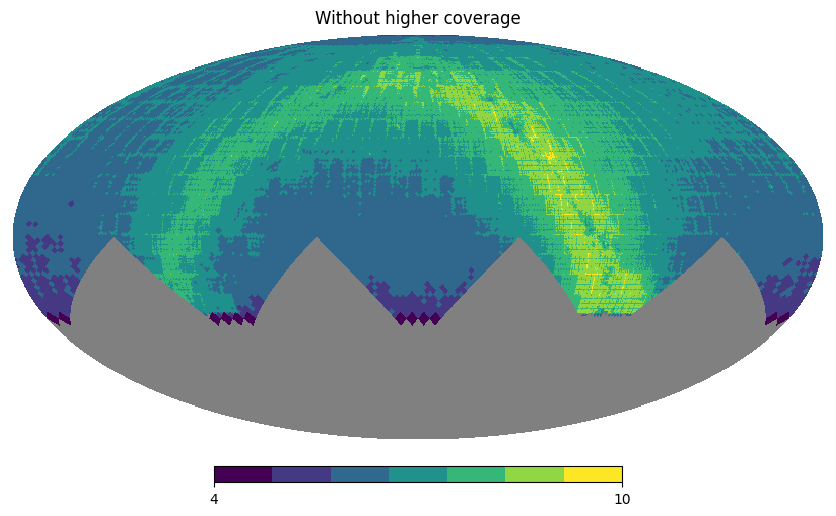

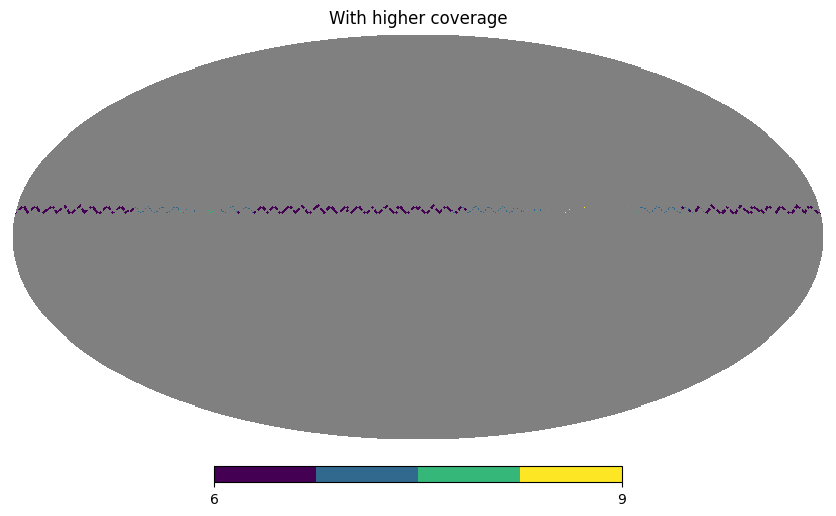

In [52]:
plot_pixels(ztf_source.hc_structure)
plot_pixels(dummy_catalog.hc_structure)
plot_pixel_list(align_trees(ztf_source.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree).pixel_tree.get_healpix_pixels(), plot_title="Without higher coverage")
plot_pixel_list(align_with_mocs(ztf_source.hc_structure.pixel_tree, dummy_catalog.hc_structure.pixel_tree, ztf_source_moc, dummy_catalog_moc).pixel_tree.get_healpix_pixels(), plot_title="With higher coverage")

## Outer Alignments

Some use cases need joins that don't need only the intersecting coverages. Any general spatial joins that use `outer`, `left`, or `right` methods need the mapping to use these methods respectively. Crossmatches that want to include non-matches also need this functionality, and we also use this outer `type` of alignment when generating the margin cache.

With the PixelTree, we have methods for performing other alignments, and can use the same MOC method but by changing the MOC intersection. (For left and right we would just use the left and right mocs, for outer we'd use the moc union)

In [53]:
def outer_align_with_mocs(left, right, mocl, mocr):
    union = mocl.union(mocr)
    alignment = align_trees(left, right, alignment_type='outer')
    return filter_alignment_by_moc(alignment, union)

In [54]:
outer_align_with_mocs(gaia.hc_structure.pixel_tree, ztf.hc_structure.pixel_tree, gaia_moc, ztf_moc).pixel_mapping

,primary_Norder,primary_Npix,join_Norder,join_Npix,aligned_Norder,aligned_Npix
0,2,0,3,0,3,0
1,2,0,3,1,3,1
2,2,0,3,2,3,2
3,2,0,3,3,3,3
4,3,4,3,4,3,4
...,...,...,...,...,...,...
4705,4,3067,4,3067,4,3067
4706,3,767,4,3068,4,3068
4707,3,767,4,3069,4,3069
4708,3,767,4,3070,4,3070


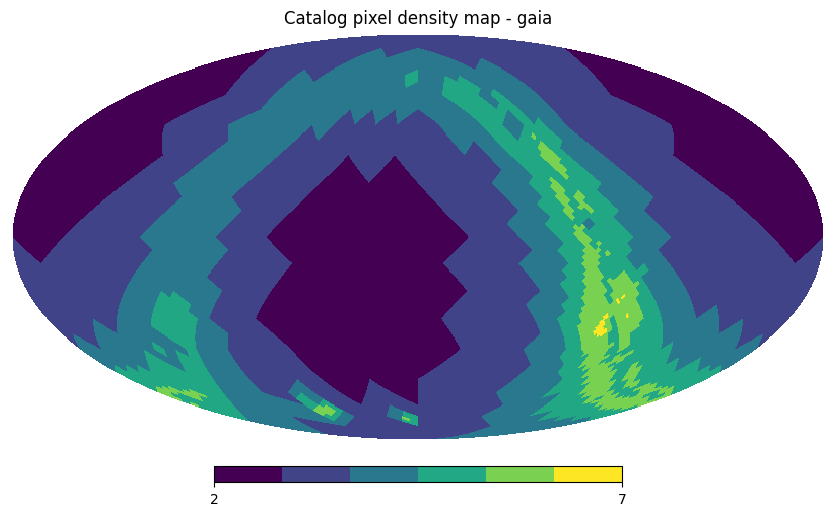

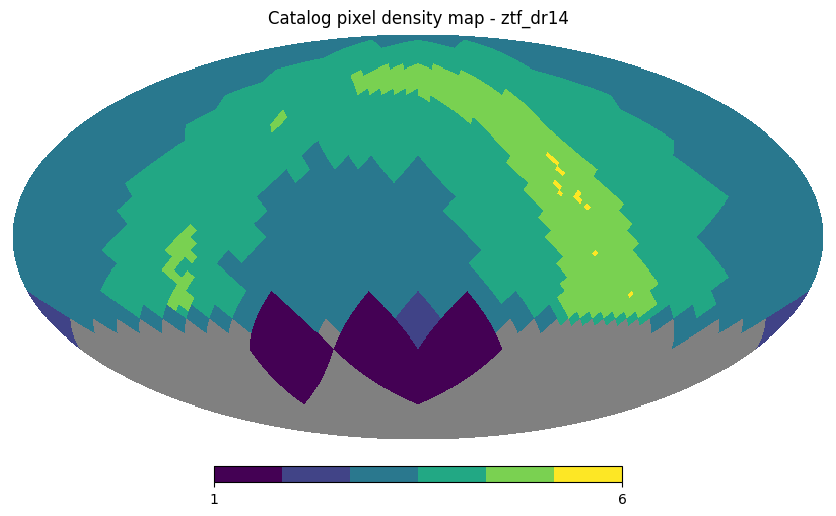

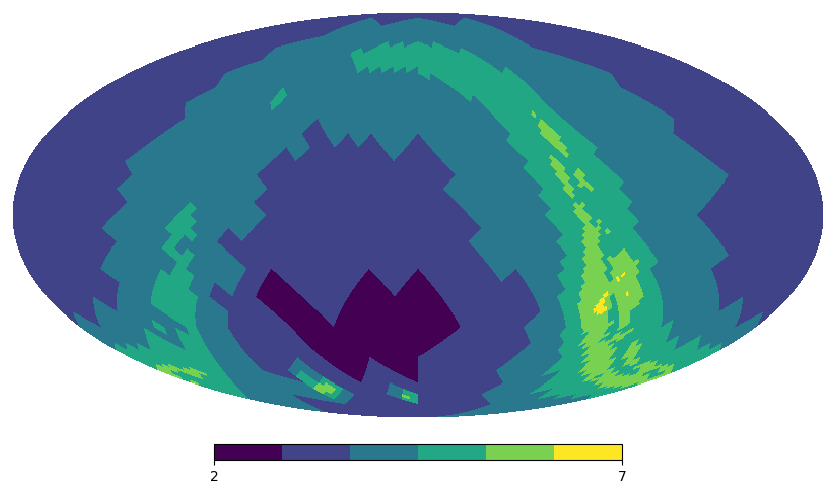

In [55]:
plot_pixels(gaia.hc_structure)
plot_pixels(ztf.hc_structure)
plot_pixel_list(outer_align_with_mocs(gaia.hc_structure.pixel_tree, ztf.hc_structure.pixel_tree, gaia_moc, ztf_moc).pixel_tree.get_healpix_pixels())